# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil
import utils

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
        
class MyResNet18_333_c64(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(MyResNet18_333_c64, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # block 1
            net.add(nn.Conv2D(channels=64, kernel_size=3, strides=1, padding=1),
                   nn.BatchNorm(),
                   nn.Activation(activation='relu'))
            # block 2
            for _ in range(3):
                net.add(Residual(channels=64))
            # block 3
            net.add(Residual(channels=128, same_shape=False))
            for _ in range(3):
                net.add(Residual(channels=128))
            # block 4
            net.add(Residual(channels=256, same_shape=False))
            for _ in range(3):
                net.add(Residual(channels=256))
            # block 5
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
    
    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print 'Block %d output %s' % (i+1, out.shape)
        return out

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, arrayds=False):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3. analysis result

## 3.1 function define

In [4]:
from cifar10_utils import show_images
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels_dict = {}
for i, l in enumerate(text_labels):
    labels_dict[l] = i
    
def inv_normalize(data, clip=True):
    mean=np.array([0.4914, 0.4822, 0.4465])
    std=np.array([0.2023, 0.1994, 0.2010])
    images = data.transpose((0, 2, 3, 1))
    if isinstance(images, mx.nd.NDArray):
        images = images.asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images
    
def show_data(data, clip=True):
    images = inv_normalize(data, clip)
    show_images(images)
    
def save_wrong_result_for_net(net, net_name):
    wrong_datas, wrong_probs, wrong_labels = None, None, None
    for data, label in test_data:
        prob = nd.softmax(net(data.as_in_context(ctx)), axis=1).asnumpy()
        y = prob.argmax(axis=1)
        label = label.reshape((-1,)).as_in_context(ctx).asnumpy()
        pos = (y != label)
        data = data.asnumpy()
        wrong_images =  data[pos]
        if wrong_images.shape[0] > 0:
            wrong_images = inv_normalize(wrong_images, clip=False)
            if wrong_datas is None:
                wrong_datas = wrong_images
                wrong_probs = prob[pos]
                wrong_labels = label[pos]
            else:
                wrong_datas = np.concatenate((wrong_datas, wrong_images), axis=0)
                wrong_probs = np.concatenate((wrong_probs, prob[pos]), axis=0)
                wrong_labels = np.concatenate((wrong_labels, label[pos]), axis=0)
    wrong_datas = nd.array(wrong_datas)
    wrong_probs = nd.array(wrong_probs)
    wrong_labels = nd.array(wrong_labels)
    nd.save('../../tmp/wrong_images_' + net_name + '.ndarray', [wrong_datas, wrong_labels])
    nd.save('../../tmp/wrong_probs_' + net_name + '.ndarray', [wrong_probs])
    
regenerate = False

## 3.2 generate and save wrong result for net

In [5]:
_, test_data = data_loader(32, _transform_test)

In [6]:
if regenerate:
    net = ResNet(10)
    net.initialize(ctx=ctx)
    net.hybridize()
    net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    save_wrong_result_for_net(net, 'resnet18_me200e')

In [7]:
if regenerate:
    net_name = 'resnet18_me_backgrad_prob_online_iter10_lr01_softlabel005'
    net = ResNet(10)
    net.initialize(ctx=ctx)
    net.hybridize()
    net.load_params('../../models/' + net_name, ctx=ctx)
    save_wrong_result_for_net(net, net_name)

In [8]:
if regenerate:
    net_name = 'resnet18_333_c64_e200'
    net = MyResNet18_333_c64(10)
    net.initialize(ctx=ctx)
    net.hybridize()
    net.load_params('../../models/' + net_name, ctx=ctx)
    save_wrong_result_for_net(net, net_name)

## 3.3 load and simple visualize wrong result

In [53]:
wrong_datas, wrong_labels, wrong_probs = {}, {}, {}
net_name = 'resnet18_me200e'
wrong_datas[net_name], wrong_labels[net_name] = nd.load('../../tmp/wrong_images_' + net_name + '.ndarray')
wrong_probs[net_name] = nd.load('../../tmp/wrong_probs_' + net_name + '.ndarray')[0]
wrong_datas[net_name], wrong_labels[net_name], wrong_probs[net_name] = wrong_datas[net_name].asnumpy(), wrong_labels[net_name].asnumpy(), wrong_probs[net_name].asnumpy()
i, num = 0, 10

In [54]:
net_name = 'resnet18_me_backgrad_prob_online_iter10_lr01_softlabel005'
wrong_datas[net_name], wrong_labels[net_name] = nd.load('../../tmp/wrong_images_' + net_name + '.ndarray')
wrong_probs[net_name] = nd.load('../../tmp/wrong_probs_' + net_name + '.ndarray')[0]
wrong_datas[net_name], wrong_labels[net_name], wrong_probs[net_name] = wrong_datas[net_name].asnumpy(), wrong_labels[net_name].asnumpy(), wrong_probs[net_name].asnumpy()
i, num = 0, 10

In [55]:
net_name = 'resnet18_333_c64_e200'
wrong_datas[net_name], wrong_labels[net_name] = nd.load('../../tmp/wrong_images_' + net_name + '.ndarray')
wrong_probs[net_name] = nd.load('../../tmp/wrong_probs_' + net_name + '.ndarray')[0]
wrong_datas[net_name], wrong_labels[net_name], wrong_probs[net_name] = wrong_datas[net_name].asnumpy(), wrong_labels[net_name].asnumpy(), wrong_probs[net_name].asnumpy()
i, num = 0, 15

In [91]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 120
def view_wrong_images(net_name, i, num, **kargs):
    wrong_data, wrong_label, wrong_prob = wrong_datas[net_name][i:i+num], wrong_labels[net_name][i:i+num], wrong_probs[net_name][i:i+num]
    labels = [text_labels[l] for l in wrong_label.astype('int32').tolist()]
    wrongs = [text_labels[l] for l in wrong_prob.argmax(axis=1).astype('int32').tolist()]
    show_images(wrong_data, xlabels=wrongs, ylabels=labels, **kargs)
#     print 'label', 
#     print 'wrong', 
#     print 'prob for true label', wrong_prob[range(num), wrong_label.astype('int32').tolist()]

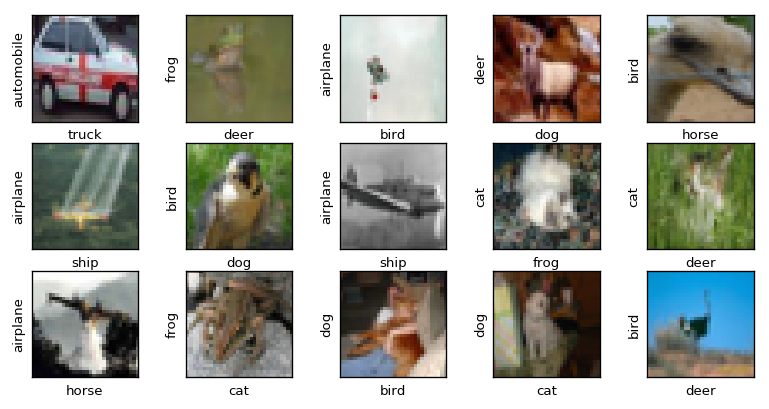

In [92]:
view_wrong_images(net_name, i, num, fontsize=8) # xlabel is true, ylabel is wrong
i += num

In [104]:
def view_data2(net_name, true_label=None, wrong_label=None, max_num=15):
    data, label, prob = wrong_datas[net_name], wrong_labels[net_name], wrong_probs[net_name]
    result = prob.argmax(axis=1)
    label = label.astype('int32')
    if true_label is not None:
        pos = (label==true_label)
        data = data[pos, :, :, :]
        prob = prob[pos, :]
        result = result[pos]
        label = label[pos]
    if wrong_label is not None:
        pos = (result==wrong_label)
        data = data[pos, :, :, :]
        prob = prob[pos, :]
        result = result[pos]
        label = label[pos]
    if data.shape[0] > 15:
        pos = range(15)
        data = data[pos, :, :, :]
        prob = prob[pos, :]
        result = result[pos]
        label = label[pos]

    if data.shape[0] > 0:
        show_images(data, xlabels=prob[:, wrong_label], ylabels=prob[:, true_label])


resnet18_333_c64_e200


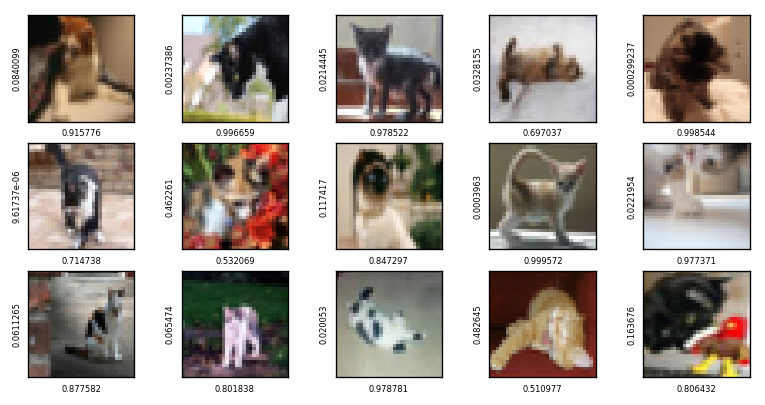

In [105]:
print net_name
find_data(net_name, true_label=labels_dict['cat'], wrong_label=labels_dict['dog'])

## 3.4 analysis statistic info

In [17]:
import pandas as pd
def wrong_table(wrong_datas, wrong_labels, wrong_probs):
    wrong_result = wrong_probs.argmax(axis=1)
    table = np.zeros(shape=(10, 10))
    for l, r in zip(wrong_labels.astype('int32'), wrong_result):
            table[l, r] += 1
    table = table.astype('int32')
    table = pd.DataFrame(table, index=text_labels, columns=text_labels)
    return table
tables = {}

In [18]:
net_name = 'resnet18_me200e'
tables[net_name] = wrong_table(wrong_datas[net_name], wrong_labels[net_name], wrong_probs[net_name])
print wrong_datas[net_name].shape[0]
tables[net_name]

618


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0,4,14,7,3,1,5,1,19,6
automobile,6,0,0,1,1,0,1,0,4,17
bird,12,0,0,15,16,9,16,4,2,0
cat,10,2,15,0,12,65,20,5,4,6
deer,3,0,9,12,0,8,6,7,3,0
dog,4,0,9,64,14,0,3,3,0,0
frog,2,0,10,15,6,1,0,0,0,0
horse,6,0,7,10,12,17,1,0,1,0
ship,28,3,2,3,0,0,1,1,0,4
truck,6,21,1,1,2,1,1,0,7,0


In [19]:
net_name = 'resnet18_me_backgrad_prob_online_iter10_lr01_softlabel005'
tables[net_name] = wrong_table(wrong_datas[net_name], wrong_labels[net_name], wrong_probs[net_name])
print wrong_datas[net_name].shape[0]
tables[net_name]

791


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0,3,10,7,7,0,5,1,29,2
automobile,2,0,3,0,0,0,3,0,4,18
bird,13,0,0,16,34,15,17,2,4,3
cat,5,2,32,0,38,63,32,3,3,2
deer,1,0,14,15,0,3,12,4,1,2
dog,4,2,9,89,25,0,11,6,1,1
frog,5,0,10,11,5,1,0,1,0,0
horse,8,0,10,10,22,18,0,0,0,2
ship,20,5,3,2,3,1,1,0,0,5
truck,12,35,3,1,1,0,4,1,13,0


In [26]:
net_name = 'resnet18_333_c64_e200'
tables[net_name] = wrong_table(wrong_datas[net_name], wrong_labels[net_name], wrong_probs[net_name])
print wrong_datas[net_name].shape[0]
tables[net_name]

476


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0,1,14,4,2,1,5,3,12,3
automobile,1,0,0,0,0,1,0,0,0,11
bird,6,1,0,9,15,12,15,10,1,1
cat,6,1,8,0,14,57,14,10,2,2
deer,0,0,8,8,0,6,5,5,1,0
dog,3,0,9,50,11,0,3,9,1,1
frog,4,0,4,9,4,3,0,1,0,0
horse,3,0,2,3,5,8,0,0,1,0
ship,14,5,3,1,0,0,0,0,0,5
truck,7,19,1,2,0,1,0,0,9,0


In [27]:
tables['resnet18_me200e'] - tables['resnet18_333_c64_e200']

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0,3,0,3,1,0,0,-2,7,3
automobile,5,0,0,1,1,-1,1,0,4,6
bird,6,-1,0,6,1,-3,1,-6,1,-1
cat,4,1,7,0,-2,8,6,-5,2,4
deer,3,0,1,4,0,2,1,2,2,0
dog,1,0,0,14,3,0,0,-6,-1,-1
frog,-2,0,6,6,2,-2,0,-1,0,0
horse,3,0,5,7,7,9,1,0,0,0
ship,14,-2,-1,2,0,0,1,1,0,-1
truck,-1,2,0,-1,2,0,1,0,-2,0


In [21]:
tables['resnet18_me200e'] - tables['resnet18_me_backgrad_prob_online_iter10_lr01_softlabel005']

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0,1,4,0,-4,1,0,0,-10,4
automobile,4,0,-3,1,1,0,-2,0,0,-1
bird,-1,0,0,-1,-18,-6,-1,2,-2,-3
cat,5,0,-17,0,-26,2,-12,2,1,4
deer,2,0,-5,-3,0,5,-6,3,2,-2
dog,0,-2,0,-25,-11,0,-8,-3,-1,-1
frog,-3,0,0,4,1,0,0,-1,0,0
horse,-2,0,-3,0,-10,-1,1,0,1,-2
ship,8,-2,-1,1,-3,-1,0,1,0,-1
truck,-6,-14,-2,0,1,1,-3,-1,-6,0
